<!-- HTML file automatically generated from DocOnce source (https://github.com/doconce/doconce/)
doconce format html week43.do.txt --no_mako -->
<!-- dom:TITLE: Week 43: Deep Learning: Recurrent Neural Networks and other Deep Learning Methods. Principal Component analysis -->

# Week 43: Deep Learning: Recurrent Neural Networks and other Deep Learning Methods. Principal Component analysis
**Morten Hjorth-Jensen**, Department of Physics, University of Oslo and Department of Physics and Astronomy and National Superconducting Cyclotron Laboratory, Michigan State University

Date: **Nov 2, 2021**

Copyright 1999-2021, Morten Hjorth-Jensen. Released under CC Attribution-NonCommercial 4.0 license

## Plans for week 43

* Thursday: Summary of Convolutional Neural Networks from week 42 and Recurrent Neural Networks

  * [Video of Lecture](https://www.uio.no/studier/emner/matnat/fys/FYS-STK3155/h21/forelesningsvideoer/LectureOctober28.mp4?vrtx=view-as-webpage)

* Friday: Recurrent Neural Networks and other Deep Learning methods such as Generalized Adversarial Neural Networks. Start discussing Principal component analysis

  * [Video of Lecture](https://www.uio.no/studier/emner/matnat/fys/FYS-STK3155/h21/forelesningsvideoer/LectureOctober29.mp4?vrtx=view-as-webpage)

**Excellent lectures on CNNs and RNNs.**

* [Video  on Convolutional Neural Networks from MIT](https://www.youtube.com/watch?v=iaSUYvmCekI&ab_channel=AlexanderAmini)

* [Video  on Recurrent Neural Networks from MIT](https://www.youtube.com/watch?v=SEnXr6v2ifU&ab_channel=AlexanderAmini)

* [Video on Deep Learning](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi)

**More resources.**

* [IN5400 at UiO Lecture](https://www.uio.no/studier/emner/matnat/ifi/IN5400/v20/material/week10/in5400_2020_week10_recurrent_neural_network.pdf)

* [CS231 at Stanford Lecture](https://www.youtube.com/watch?v=6niqTuYFZLQ&list=PLzUTmXVwsnXod6WNdg57Yc3zFx_f-RYsq&index=10&ab_channel=StanfordUniversitySchoolofEngineering)

## Reading Recommendations

* Goodfellow et al, chapter 10 on Recurrent NNs, chapters 11 and 12 on various practicalities around deep learning are also recommended.

* Aurelien Geron, chapter 14 on RNNs.

## Summary on Deep Learning Methods

We have studied fully connected neural networks (also called artifical nueral networks) and convolutional neural networks (CNNs).

The first type of deep learning networks work very well on homogeneous and structured input data while CCNs are normally tailored to recognizing images.

## CNNs in brief

In summary:

* A CNN architecture is in the simplest case a list of Layers that transform the image volume into an output volume (e.g. holding the class scores)

* There are a few distinct types of Layers (e.g. CONV/FC/RELU/POOL are by far the most popular)

* Each Layer accepts an input 3D volume and transforms it to an output 3D volume through a differentiable function

* Each Layer may or may not have parameters (e.g. CONV/FC do, RELU/POOL don’t)

* Each Layer may or may not have additional hyperparameters (e.g. CONV/FC/POOL do, RELU doesn’t)

For more material on convolutional networks, we strongly recommend
the course
[IN5400 – Machine Learning for Image Analysis](https://www.uio.no/studier/emner/matnat/ifi/IN5400/index-eng.html)
and the slides of [CS231](http://cs231n.github.io/convolutional-networks/) which is taught at Stanford University (consistently ranked as one of the top computer science programs in the world). [Michael Nielsen's book is a must read, in particular chapter 6 which deals with CNNs](http://neuralnetworksanddeeplearning.com/chap6.html).

However, both standard feed forwards networks and CNNs perform well on data with unknown length.

This is where recurrent nueral networks (RNNs) come to our rescue.

## Recurrent neural networks: Overarching view

Till now our focus has been, including convolutional neural networks
as well, on feedforward neural networks. The output or the activations
flow only in one direction, from the input layer to the output layer.

A recurrent neural network (RNN) looks very much like a feedforward
neural network, except that it also has connections pointing
backward. 

RNNs are used to analyze time series data such as stock prices, and
tell you when to buy or sell. In autonomous driving systems, they can
anticipate car trajectories and help avoid accidents. More generally,
they can work on sequences of arbitrary lengths, rather than on
fixed-sized inputs like all the nets we have discussed so far. For
example, they can take sentences, documents, or audio samples as
input, making them extremely useful for natural language processing
systems such as automatic translation and speech-to-text.

## Set up of an RNN

More to text to be added

## A simple example

In [1]:
%matplotlib inline

# Start importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential 
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras import optimizers     
from tensorflow.keras import regularizers           
from tensorflow.keras.utils import to_categorical 



# convert into dataset matrix
def convertToMatrix(data, step):
 X, Y =[], []
 for i in range(len(data)-step):
  d=i+step  
  X.append(data[i:d,])
  Y.append(data[d,])
 return np.array(X), np.array(Y)

step = 4
N = 1000    
Tp = 800    

t=np.arange(0,N)
x=np.sin(0.02*t)+2*np.random.rand(N)
df = pd.DataFrame(x)
df.head()

plt.plot(df)
plt.show()

values=df.values
train,test = values[0:Tp,:], values[Tp:N,:]

# add step elements into train and test
test = np.append(test,np.repeat(test[-1,],step))
train = np.append(train,np.repeat(train[-1,],step))
 
trainX,trainY =convertToMatrix(train,step)
testX,testY =convertToMatrix(test,step)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

model = Sequential()
model.add(SimpleRNN(units=32, input_shape=(1,step), activation="relu"))
model.add(Dense(8, activation="relu")) 
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.summary()

model.fit(trainX,trainY, epochs=100, batch_size=16, verbose=2)
trainPredict = model.predict(trainX)
testPredict= model.predict(testX)
predicted=np.concatenate((trainPredict,testPredict),axis=0)

trainScore = model.evaluate(trainX, trainY, verbose=0)
print(trainScore)

index = df.index.values
plt.plot(index,df)
plt.plot(index,predicted)
plt.axvline(df.index[Tp], c="r")
plt.show()

ModuleNotFoundError: No module named 'tensorflow'

## An extrapolation example

The following code provides an example of how recurrent neural
networks can be used to extrapolate to unknown values of physics data
sets.  Specifically, the data sets used in this program come from
a quantum mechanical many-body calculation of energies as functions of the number of particles.

In [2]:

# For matrices and calculations
import numpy as np
# For machine learning (backend for keras)
import tensorflow as tf
# User-friendly machine learning library
# Front end for TensorFlow
import tensorflow.keras
# Different methods from Keras needed to create an RNN
# This is not necessary but it shortened function calls 
# that need to be used in the code.
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Input
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
# For timing the code
from timeit import default_timer as timer
# For plotting
import matplotlib.pyplot as plt


# The data set
datatype='VaryDimension'
X_tot = np.arange(2, 42, 2)
y_tot = np.array([-0.03077640549, -0.08336233266, -0.1446729567, -0.2116753732, -0.2830637392, -0.3581341341, -0.436462435, -0.5177783846,
	-0.6019067271, -0.6887363571, -0.7782028952, -0.8702784034, -0.9649652536, -1.062292565, -1.16231451, 
	-1.265109911, -1.370782966, -1.479465113, -1.591317992, -1.70653767])

## Formatting the Data

The way the recurrent neural networks are trained in this program
differs from how machine learning algorithms are usually trained.
Typically a machine learning algorithm is trained by learning the
relationship between the x data and the y data.  In this program, the
recurrent neural network will be trained to recognize the relationship
in a sequence of y values.  This is type of data formatting is
typically used time series forcasting, but it can also be used in any
extrapolation (time series forecasting is just a specific type of
extrapolation along the time axis).  This method of data formatting
does not use the x data and assumes that the y data are evenly spaced.

For a standard machine learning algorithm, the training data has the
form of (x,y) so the machine learning algorithm learns to assiciate a
y value with a given x value.  This is useful when the test data has x
values within the same range as the training data.  However, for this
application, the x values of the test data are outside of the x values
of the training data and the traditional method of training a machine
learning algorithm does not work as well.  For this reason, the
recurrent neural network is trained on sequences of y values of the
form ((y1, y2), y3), so that the network is concerned with learning
the pattern of the y data and not the relation between the x and y
data.  As long as the pattern of y data outside of the training region
stays relatively stable compared to what was inside the training
region, this method of training can produce accurate extrapolations to
y values far removed from the training data set.

<!--  -->
<!-- The idea behind formatting the data in this way comes from [this resource](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/) and [this one](https://fairyonice.github.io/Understand-Keras%27s-RNN-behind-the-scenes-with-a-sin-wave-example.html). -->
<!--  -->
<!-- The following method takes in a y data set and formats it so the "x data" are of the form (y1, y2) and the "y data" are of the form y3, with extra brackets added in to make the resulting arrays compatable with both Keras and Tensorflow. -->
<!--  -->
<!-- Note: Using a sequence length of two is not required for time series forecasting so any lenght of sequence could be used (for example instead of ((y1, y2) y3) you could change the length of sequence to be 4 and the resulting data points would have the form ((y1, y2, y3, y4), y5)).  While the following method can be used to create a data set of any sequence length, the remainder of the code expects the length of sequence to be 2.  This is because the data sets are very small and the higher the lenght of the sequence the less resulting data points. -->

In [3]:
# FORMAT_DATA
def format_data(data, length_of_sequence = 2):  
    """
        Inputs:
            data(a numpy array): the data that will be the inputs to the recurrent neural
                network
            length_of_sequence (an int): the number of elements in one iteration of the
                sequence patter.  For a function approximator use length_of_sequence = 2.
        Returns:
            rnn_input (a 3D numpy array): the input data for the recurrent neural network.  Its
                dimensions are length of data - length of sequence, length of sequence, 
                dimnsion of data
            rnn_output (a numpy array): the training data for the neural network
        Formats data to be used in a recurrent neural network.
    """

    X, Y = [], []
    for i in range(len(data)-length_of_sequence):
        # Get the next length_of_sequence elements
        a = data[i:i+length_of_sequence]
        # Get the element that immediately follows that
        b = data[i+length_of_sequence]
        # Reshape so that each data point is contained in its own array
        a = np.reshape (a, (len(a), 1))
        X.append(a)
        Y.append(b)
    rnn_input = np.array(X)
    rnn_output = np.array(Y)

    return rnn_input, rnn_output


# ## Defining the Recurrent Neural Network Using Keras
# 
# The following method defines a simple recurrent neural network in keras consisting of one input layer, one hidden layer, and one output layer.

def rnn(length_of_sequences, batch_size = None, stateful = False):
    """
        Inputs:
            length_of_sequences (an int): the number of y values in "x data".  This is determined
                when the data is formatted
            batch_size (an int): Default value is None.  See Keras documentation of SimpleRNN.
            stateful (a boolean): Default value is False.  See Keras documentation of SimpleRNN.
        Returns:
            model (a Keras model): The recurrent neural network that is built and compiled by this
                method
        Builds and compiles a recurrent neural network with one hidden layer and returns the model.
    """
    # Number of neurons in the input and output layers
    in_out_neurons = 1
    # Number of neurons in the hidden layer
    hidden_neurons = 200
    # Define the input layer
    inp = Input(batch_shape=(batch_size, 
                length_of_sequences, 
                in_out_neurons))  
    # Define the hidden layer as a simple RNN layer with a set number of neurons and add it to 
    # the network immediately after the input layer
    rnn = SimpleRNN(hidden_neurons, 
                    return_sequences=False,
                    stateful = stateful,
                    name="RNN")(inp)
    # Define the output layer as a dense neural network layer (standard neural network layer)
    #and add it to the network immediately after the hidden layer.
    dens = Dense(in_out_neurons,name="dense")(rnn)
    # Create the machine learning model starting with the input layer and ending with the 
    # output layer
    model = Model(inputs=[inp],outputs=[dens])
    # Compile the machine learning model using the mean squared error function as the loss 
    # function and an Adams optimizer.
    model.compile(loss="mean_squared_error", optimizer="adam")  
    return model

## Predicting New Points With A Trained Recurrent Neural Network

In [4]:
def test_rnn (x1, y_test, plot_min, plot_max):
    """
        Inputs:
            x1 (a list or numpy array): The complete x component of the data set
            y_test (a list or numpy array): The complete y component of the data set
            plot_min (an int or float): the smallest x value used in the training data
            plot_max (an int or float): the largest x valye used in the training data
        Returns:
            None.
        Uses a trained recurrent neural network model to predict future points in the 
        series.  Computes the MSE of the predicted data set from the true data set, saves
        the predicted data set to a csv file, and plots the predicted and true data sets w
        while also displaying the data range used for training.
    """
    # Add the training data as the first dim points in the predicted data array as these
    # are known values.
    y_pred = y_test[:dim].tolist()
    # Generate the first input to the trained recurrent neural network using the last two 
    # points of the training data.  Based on how the network was trained this means that it
    # will predict the first point in the data set after the training data.  All of the 
    # brackets are necessary for Tensorflow.
    next_input = np.array([[[y_test[dim-2]], [y_test[dim-1]]]])
    # Save the very last point in the training data set.  This will be used later.
    last = [y_test[dim-1]]

    # Iterate until the complete data set is created.
    for i in range (dim, len(y_test)):
        # Predict the next point in the data set using the previous two points.
        next = model.predict(next_input)
        # Append just the number of the predicted data set
        y_pred.append(next[0][0])
        # Create the input that will be used to predict the next data point in the data set.
        next_input = np.array([[last, next[0]]], dtype=np.float64)
        last = next

    # Print the mean squared error between the known data set and the predicted data set.
    print('MSE: ', np.square(np.subtract(y_test, y_pred)).mean())
    # Save the predicted data set as a csv file for later use
    name = datatype + 'Predicted'+str(dim)+'.csv'
    np.savetxt(name, y_pred, delimiter=',')
    # Plot the known data set and the predicted data set.  The red box represents the region that was used
    # for the training data.
    fig, ax = plt.subplots()
    ax.plot(x1, y_test, label="true", linewidth=3)
    ax.plot(x1, y_pred, 'g-.',label="predicted", linewidth=4)
    ax.legend()
    # Created a red region to represent the points used in the training data.
    ax.axvspan(plot_min, plot_max, alpha=0.25, color='red')
    plt.show()

# Check to make sure the data set is complete
assert len(X_tot) == len(y_tot)

# This is the number of points that will be used in as the training data
dim=12

# Separate the training data from the whole data set
X_train = X_tot[:dim]
y_train = y_tot[:dim]


# Generate the training data for the RNN, using a sequence of 2
rnn_input, rnn_training = format_data(y_train, 2)


# Create a recurrent neural network in Keras and produce a summary of the 
# machine learning model
model = rnn(length_of_sequences = rnn_input.shape[1])
model.summary()

# Start the timer.  Want to time training+testing
start = timer()
# Fit the model using the training data genenerated above using 150 training iterations and a 5%
# validation split.  Setting verbose to True prints information about each training iteration.
hist = model.fit(rnn_input, rnn_training, batch_size=None, epochs=150, 
                 verbose=True,validation_split=0.05)

for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)

plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("The final validation loss: {}".format(hist.history["val_loss"][-1]))
plt.legend()
plt.show()

# Use the trained neural network to predict more points of the data set
test_rnn(X_tot, y_tot, X_tot[0], X_tot[dim-1])
# Stop the timer and calculate the total time needed.
end = timer()
print('Time: ', end-start)

## Other Things to Try

Changing the size of the recurrent neural network and its parameters
can drastically change the results you get from the model.  The below
code takes the simple recurrent neural network from above and adds a
second hidden layer, changes the number of neurons in the hidden
layer, and explicitly declares the activation function of the hidden
layers to be a sigmoid function.  The loss function and optimizer can
also be changed but are kept the same as the above network.  These
parameters can be tuned to provide the optimal result from the
network.  For some ideas on how to improve the performance of a
[recurrent neural network](https://danijar.com/tips-for-training-recurrent-neural-networks).

In [5]:
def rnn_2layers(length_of_sequences, batch_size = None, stateful = False):
    """
        Inputs:
            length_of_sequences (an int): the number of y values in "x data".  This is determined
                when the data is formatted
            batch_size (an int): Default value is None.  See Keras documentation of SimpleRNN.
            stateful (a boolean): Default value is False.  See Keras documentation of SimpleRNN.
        Returns:
            model (a Keras model): The recurrent neural network that is built and compiled by this
                method
        Builds and compiles a recurrent neural network with two hidden layers and returns the model.
    """
    # Number of neurons in the input and output layers
    in_out_neurons = 1
    # Number of neurons in the hidden layer, increased from the first network
    hidden_neurons = 500
    # Define the input layer
    inp = Input(batch_shape=(batch_size, 
                length_of_sequences, 
                in_out_neurons))  
    # Create two hidden layers instead of one hidden layer.  Explicitly set the activation
    # function to be the sigmoid function (the default value is hyperbolic tangent)
    rnn1 = SimpleRNN(hidden_neurons, 
                    return_sequences=True,  # This needs to be True if another hidden layer is to follow
                    stateful = stateful, activation = 'sigmoid',
                    name="RNN1")(inp)
    rnn2 = SimpleRNN(hidden_neurons, 
                    return_sequences=False, activation = 'sigmoid',
                    stateful = stateful,
                    name="RNN2")(rnn1)
    # Define the output layer as a dense neural network layer (standard neural network layer)
    #and add it to the network immediately after the hidden layer.
    dens = Dense(in_out_neurons,name="dense")(rnn2)
    # Create the machine learning model starting with the input layer and ending with the 
    # output layer
    model = Model(inputs=[inp],outputs=[dens])
    # Compile the machine learning model using the mean squared error function as the loss 
    # function and an Adams optimizer.
    model.compile(loss="mean_squared_error", optimizer="adam")  
    return model

# Check to make sure the data set is complete
assert len(X_tot) == len(y_tot)

# This is the number of points that will be used in as the training data
dim=12

# Separate the training data from the whole data set
X_train = X_tot[:dim]
y_train = y_tot[:dim]


# Generate the training data for the RNN, using a sequence of 2
rnn_input, rnn_training = format_data(y_train, 2)


# Create a recurrent neural network in Keras and produce a summary of the 
# machine learning model
model = rnn_2layers(length_of_sequences = 2)
model.summary()

# Start the timer.  Want to time training+testing
start = timer()
# Fit the model using the training data genenerated above using 150 training iterations and a 5%
# validation split.  Setting verbose to True prints information about each training iteration.
hist = model.fit(rnn_input, rnn_training, batch_size=None, epochs=150, 
                 verbose=True,validation_split=0.05)


# This section plots the training loss and the validation loss as a function of training iteration.
# This is not required for analyzing the couple cluster data but can help determine if the network is
# being overtrained.
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)

plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("The final validation loss: {}".format(hist.history["val_loss"][-1]))
plt.legend()
plt.show()

# Use the trained neural network to predict more points of the data set
test_rnn(X_tot, y_tot, X_tot[0], X_tot[dim-1])
# Stop the timer and calculate the total time needed.
end = timer()
print('Time: ', end-start)

## Other Types of Recurrent Neural Networks

Besides a simple recurrent neural network layer, there are two other
commonly used types of recurrent neural network layers: Long Short
Term Memory (LSTM) and Gated Recurrent Unit (GRU).  For a short
introduction to these layers see <https://medium.com/mindboard/lstm-vs-gru-experimental-comparison-955820c21e8b>
and <https://medium.com/mindboard/lstm-vs-gru-experimental-comparison-955820c21e8b>.

The first network created below is similar to the previous network,
but it replaces the SimpleRNN layers with LSTM layers.  The second
network below has two hidden layers made up of GRUs, which are
preceeded by two dense (feeddorward) neural network layers.  These
dense layers "preprocess" the data before it reaches the recurrent
layers.  This architecture has been shown to improve the performance
of recurrent neural networks (see the link above and also
<https://arxiv.org/pdf/1807.02857.pdf>.

In [6]:
def lstm_2layers(length_of_sequences, batch_size = None, stateful = False):
    """
        Inputs:
            length_of_sequences (an int): the number of y values in "x data".  This is determined
                when the data is formatted
            batch_size (an int): Default value is None.  See Keras documentation of SimpleRNN.
            stateful (a boolean): Default value is False.  See Keras documentation of SimpleRNN.
        Returns:
            model (a Keras model): The recurrent neural network that is built and compiled by this
                method
        Builds and compiles a recurrent neural network with two LSTM hidden layers and returns the model.
    """
    # Number of neurons on the input/output layer and the number of neurons in the hidden layer
    in_out_neurons = 1
    hidden_neurons = 250
    # Input Layer
    inp = Input(batch_shape=(batch_size, 
                length_of_sequences, 
                in_out_neurons)) 
    # Hidden layers (in this case they are LSTM layers instead if SimpleRNN layers)
    rnn= LSTM(hidden_neurons, 
                    return_sequences=True,
                    stateful = stateful,
                    name="RNN", use_bias=True, activation='tanh')(inp)
    rnn1 = LSTM(hidden_neurons, 
                    return_sequences=False,
                    stateful = stateful,
                    name="RNN1", use_bias=True, activation='tanh')(rnn)
    # Output layer
    dens = Dense(in_out_neurons,name="dense")(rnn1)
    # Define the midel
    model = Model(inputs=[inp],outputs=[dens])
    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')  
    # Return the model
    return model

def dnn2_gru2(length_of_sequences, batch_size = None, stateful = False):
    """
        Inputs:
            length_of_sequences (an int): the number of y values in "x data".  This is determined
                when the data is formatted
            batch_size (an int): Default value is None.  See Keras documentation of SimpleRNN.
            stateful (a boolean): Default value is False.  See Keras documentation of SimpleRNN.
        Returns:
            model (a Keras model): The recurrent neural network that is built and compiled by this
                method
        Builds and compiles a recurrent neural network with four hidden layers (two dense followed by
        two GRU layers) and returns the model.
    """    
    # Number of neurons on the input/output layers and hidden layers
    in_out_neurons = 1
    hidden_neurons = 250
    # Input layer
    inp = Input(batch_shape=(batch_size, 
                length_of_sequences, 
                in_out_neurons)) 
    # Hidden Dense (feedforward) layers
    dnn = Dense(hidden_neurons/2, activation='relu', name='dnn')(inp)
    dnn1 = Dense(hidden_neurons/2, activation='relu', name='dnn1')(dnn)
    # Hidden GRU layers
    rnn1 = GRU(hidden_neurons, 
                    return_sequences=True,
                    stateful = stateful,
                    name="RNN1", use_bias=True)(dnn1)
    rnn = GRU(hidden_neurons, 
                    return_sequences=False,
                    stateful = stateful,
                    name="RNN", use_bias=True)(rnn1)
    # Output layer
    dens = Dense(in_out_neurons,name="dense")(rnn)
    # Define the model
    model = Model(inputs=[inp],outputs=[dens])
    # Compile the mdoel
    model.compile(loss='mean_squared_error', optimizer='adam')  
    # Return the model
    return model

# Check to make sure the data set is complete
assert len(X_tot) == len(y_tot)

# This is the number of points that will be used in as the training data
dim=12

# Separate the training data from the whole data set
X_train = X_tot[:dim]
y_train = y_tot[:dim]


# Generate the training data for the RNN, using a sequence of 2
rnn_input, rnn_training = format_data(y_train, 2)


# Create a recurrent neural network in Keras and produce a summary of the 
# machine learning model
# Change the method name to reflect which network you want to use
model = dnn2_gru2(length_of_sequences = 2)
model.summary()

# Start the timer.  Want to time training+testing
start = timer()
# Fit the model using the training data genenerated above using 150 training iterations and a 5%
# validation split.  Setting verbose to True prints information about each training iteration.
hist = model.fit(rnn_input, rnn_training, batch_size=None, epochs=150, 
                 verbose=True,validation_split=0.05)


# This section plots the training loss and the validation loss as a function of training iteration.
# This is not required for analyzing the couple cluster data but can help determine if the network is
# being overtrained.
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)

plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("The final validation loss: {}".format(hist.history["val_loss"][-1]))
plt.legend()
plt.show()

# Use the trained neural network to predict more points of the data set
test_rnn(X_tot, y_tot, X_tot[0], X_tot[dim-1])
# Stop the timer and calculate the total time needed.
end = timer()
print('Time: ', end-start)


# ### Training Recurrent Neural Networks in the Standard Way (i.e. learning the relationship between the X and Y data)
# 
# Finally, comparing the performace of a recurrent neural network using the standard data formatting to the performance of the network with time sequence data formatting shows the benefit of this type of data formatting with extrapolation.

# Check to make sure the data set is complete
assert len(X_tot) == len(y_tot)

# This is the number of points that will be used in as the training data
dim=12

# Separate the training data from the whole data set
X_train = X_tot[:dim]
y_train = y_tot[:dim]

# Reshape the data for Keras specifications
X_train = X_train.reshape((dim, 1))
y_train = y_train.reshape((dim, 1))


# Create a recurrent neural network in Keras and produce a summary of the 
# machine learning model
# Set the sequence length to 1 for regular data formatting 
model = rnn(length_of_sequences = 1)
model.summary()

# Start the timer.  Want to time training+testing
start = timer()
# Fit the model using the training data genenerated above using 150 training iterations and a 5%
# validation split.  Setting verbose to True prints information about each training iteration.
hist = model.fit(X_train, y_train, batch_size=None, epochs=150, 
                 verbose=True,validation_split=0.05)


# This section plots the training loss and the validation loss as a function of training iteration.
# This is not required for analyzing the couple cluster data but can help determine if the network is
# being overtrained.
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)

plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("The final validation loss: {}".format(hist.history["val_loss"][-1]))
plt.legend()
plt.show()

# Use the trained neural network to predict the remaining data points
X_pred = X_tot[dim:]
X_pred = X_pred.reshape((len(X_pred), 1))
y_model = model.predict(X_pred)
y_pred = np.concatenate((y_tot[:dim], y_model.flatten()))

# Plot the known data set and the predicted data set.  The red box represents the region that was used
# for the training data.
fig, ax = plt.subplots()
ax.plot(X_tot, y_tot, label="true", linewidth=3)
ax.plot(X_tot, y_pred, 'g-.',label="predicted", linewidth=4)
ax.legend()
# Created a red region to represent the points used in the training data.
ax.axvspan(X_tot[0], X_tot[dim], alpha=0.25, color='red')
plt.show()

# Stop the timer and calculate the total time needed.
end = timer()
print('Time: ', end-start)

## Generative Models

**Generative models** describe a class of statistical models that are a contrast
to **discriminative models**. Informally we say that generative models can
generate new data instances while discriminative models discriminate between
different kinds of data instances. A generative model could generate new photos
of animals that look like 'real' animals while a discriminative model could tell
a dog from a cat. More formally, given a data set $x$ and a set of labels /
targets $y$. Generative models capture the joint probability $p(x, y)$, or
just $p(x)$ if there are no labels, while discriminative models capture the
conditional probability $p(y | x)$. Discriminative models generally try to draw
boundaries in the data space (often high dimensional), while generative models
try to model how data is placed throughout the space.

**Note**: this material is thanks to Linus Ekstrøm.

## Generative Adversarial Networks

**Generative Adversarial Networks** are a type of unsupervised machine learning
algorithm proposed by [Goodfellow et. al](https://arxiv.org/pdf/1406.2661.pdf)
in 2014 (short and good article).

The simplest formulation of
the model is based on a game theoretic approach, *zero sum game*, where we pit
two neural networks against one another. We define two rival networks, one
generator $g$, and one discriminator $d$. The generator directly produces
samples

<!-- Equation labels as ordinary links -->
<div id="_auto1"></div>

$$
\begin{equation}
    x = g(z; \theta^{(g)})
\label{_auto1} \tag{1}
\end{equation}
$$

## Discriminator
The discriminator attempts to distinguish between samples drawn from the
training data and samples drawn from the generator. In other words, it tries to
tell the difference between the fake data produced by $g$ and the actual data
samples we want to do prediction on. The discriminator outputs a probability
value given by

<!-- Equation labels as ordinary links -->
<div id="_auto2"></div>

$$
\begin{equation}
    d(x; \theta^{(d)})
\label{_auto2} \tag{2}
\end{equation}
$$

indicating the probability that $x$ is a real training example rather than a
fake sample the generator has generated. The simplest way to formulate the
learning process in a generative adversarial network is a zero-sum game, in
which a function

<!-- Equation labels as ordinary links -->
<div id="_auto3"></div>

$$
\begin{equation}
    v(\theta^{(g)}, \theta^{(d)})
\label{_auto3} \tag{3}
\end{equation}
$$

determines the reward for the discriminator, while the generator gets the
conjugate reward

<!-- Equation labels as ordinary links -->
<div id="_auto4"></div>

$$
\begin{equation}
    -v(\theta^{(g)}, \theta^{(d)})
\label{_auto4} \tag{4}
\end{equation}
$$

## Learning Process

During learning both of the networks maximize their own reward function, so that
the generator gets better and better at tricking the discriminator, while the
discriminator gets better and better at telling the difference between the fake
and real data. The generator and discriminator alternate on which one trains at
one time (i.e. for one epoch). In other words, we keep the generator constant
and train the discriminator, then we keep the discriminator constant to train
the generator and repeat. It is this back and forth dynamic which lets GANs
tackle otherwise intractable generative problems. As the generator improves with
 training, the discriminator's performance gets worse because it cannot easily
 tell the difference between real and fake. If the generator ends up succeeding
 perfectly, the the discriminator will do no better than random guessing i.e.
 50\%. This progression in the training poses a problem for the convergence
 criteria for GANs. The discriminator feedback gets less meaningful over time,
 if we continue training after this point then the generator is effectively
 training on junk data which can undo the learning up to that point. Therefore,
 we stop training when the discriminator starts outputting $1/2$ everywhere.

## More about the Learning Process

At convergence we have

<!-- Equation labels as ordinary links -->
<div id="_auto5"></div>

$$
\begin{equation}
    g^* = \underset{g}{\mathrm{argmin}}\hspace{2pt}
          \underset{d}{\mathrm{max}}v(\theta^{(g)}, \theta^{(d)})
\label{_auto5} \tag{5}
\end{equation}
$$

The default choice for $v$ is

<!-- Equation labels as ordinary links -->
<div id="_auto6"></div>

$$
\begin{equation}
    v(\theta^{(g)}, \theta^{(d)}) = \mathbb{E}_{x\sim p_\mathrm{data}}\log d(x)
                                  + \mathbb{E}_{x\sim p_\mathrm{model}}
                                  \log (1 - d(x))
\label{_auto6} \tag{6}
\end{equation}
$$

The main motivation for the design of GANs is that the learning process requires
neither approximate inference (variational autoencoders for example) nor
approximation of a partition function. In the case where

<!-- Equation labels as ordinary links -->
<div id="_auto7"></div>

$$
\begin{equation}
    \underset{d}{\mathrm{max}}v(\theta^{(g)}, \theta^{(d)})
\label{_auto7} \tag{7}
\end{equation}
$$

is convex in $\theta^{(g)} then the procedure is guaranteed to converge and is
asymptotically consistent
( [Seth Lloyd on QuGANs](https://arxiv.org/pdf/1804.09139.pdf)  ).

## Additional References
This is in
general not the case and it is possible to get situations where the training
process never converges because the generator and discriminator chase one
another around in the parameter space indefinitely. A much deeper discussion on
the currently open research problem of GAN convergence is available
[here](https://www.deeplearningbook.org/contents/generative_models.html). To
anyone interested in learning more about GANs it is a highly recommended read.
Direct quote: "In this best-performing formulation, the generator aims to
increase the log probability that the discriminator makes a mistake, rather than
aiming to decrease the log probability that the discriminator makes the correct
prediction." [Another interesting read](https://arxiv.org/abs/1701.00160)

## Writing Our First Generative Adversarial Network
Let us now move on to actually implementing a GAN in tensorflow. We will study
the performance of our GAN on the MNIST dataset. This code is based on and
adapted from the
[google tutorial](https://www.tensorflow.org/tutorials/generative/dcgan)

First we import our libraries

In [7]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

Next we define our hyperparameters and import our data the usual way

In [8]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256
EPOCHS = 30

data = tf.keras.datasets.mnist.load_data()
(train_images, train_labels), (test_images, test_labels) = data
train_images = np.reshape(train_images, (train_images.shape[0],
                                         28,
                                         28,
                                         1)).astype('float32')

# we normalize between -1 and 1
train_images = (train_images - 127.5) / 127.5
training_dataset = tf.data.Dataset.from_tensor_slices(
                      train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## MNIST and GANs

Let's have a quick look

In [9]:
plt.imshow(train_images[0], cmap='Greys')
plt.show()

Now we define our two models. This is where the 'magic' happens. There are a
huge amount of possible formulations for both models. A lot of engineering and
trial and error can be done here to try to produce better performing models. For
more advanced GANs this is by far the step where you can 'make or break' a
model.

We start with the generator. As stated in the introductory text the generator
$g$ upsamples from a random sample to the shape of what we want to predict. In
our case we are trying to predict MNIST images ($28\times 28$ pixels).

In [10]:
def generator_model():
    """
    The generator uses upsampling layers tf.keras.layers.Conv2DTranspose() to
    produce an image from a random seed. We start with a Dense layer taking this
    random sample as an input and subsequently upsample through multiple
    convolutional layers.
    """

    # we define our model
    model = tf.keras.Sequential()


    # adding our input layer. Dense means that every neuron is connected and
    # the input shape is the shape of our random noise. The units need to match
    # in some sense the upsampling strides to reach our desired output shape.
    # we are using 100 random numbers as our seed
    model.add(layers.Dense(units=7*7*BATCH_SIZE,
                           use_bias=False,
                           input_shape=(100, )))
    # we normalize the output form the Dense layer
    model.add(layers.BatchNormalization())
    # and add an activation function to our 'layer'. LeakyReLU avoids vanishing
    # gradient problem
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, BATCH_SIZE)))
    assert model.output_shape == (None, 7, 7, BATCH_SIZE)
    # even though we just added four keras layers we think of everything above
    # as 'one' layer

    # next we add our upscaling convolutional layers
    model.add(layers.Conv2DTranspose(filters=128,
                                     kernel_size=(5, 5),
                                     strides=(1, 1),
                                     padding='same',
                                     use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    assert model.output_shape == (None, 7, 7, 128)

    model.add(layers.Conv2DTranspose(filters=64,
                                     kernel_size=(5, 5),
                                     strides=(2, 2),
                                     padding='same',
                                     use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    assert model.output_shape == (None, 14, 14, 64)

    model.add(layers.Conv2DTranspose(filters=1,
                                     kernel_size=(5, 5),
                                     strides=(2, 2),
                                     padding='same',
                                     use_bias=False,
                                     activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

And there we have our 'simple' generator model. Now we move on to defining our
discriminator model $d$, which is a convolutional neural network based image
classifier.

In [11]:
def discriminator_model():
    """
    The discriminator is a convolutional neural network based image classifier
    """

    # we define our model
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(filters=64,
                            kernel_size=(5, 5),
                            strides=(2, 2),
                            padding='same',
                            input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    # adding a dropout layer as you do in conv-nets
    model.add(layers.Dropout(0.3))


    model.add(layers.Conv2D(filters=128,
                            kernel_size=(5, 5),
                            strides=(2, 2),
                            padding='same'))
    model.add(layers.LeakyReLU())
    # adding a dropout layer as you do in conv-nets
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

## Other Models
Let us take a look at our models. **Note**: double click images for bigger view.

In [12]:
generator = generator_model()
plot_model(generator, show_shapes=True, rankdir='LR')

In [13]:
discriminator = discriminator_model()
plot_model(discriminator, show_shapes=True, rankdir='LR')

Next we need a few helper objects we will use in training

In [14]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

The first object, *cross_entropy* is our loss function and the two others are
our optimizers. Notice we use the same learning rate for both $g$ and $d$. This
is because they need to improve their accuracy at approximately equal speeds to
get convergence (not necessarily exactly equal). Now we define our loss
functions

In [15]:
def generator_loss(fake_output):
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)

    return loss

In [16]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_liks(fake_output), fake_output)
    total_loss = real_loss + fake_loss

    return total_loss

Next we define a kind of seed to help us compare the learning process over
multiple training epochs.

In [17]:
noise_dimension = 100
n_examples_to_generate = 16
seed_images = tf.random.normal([n_examples_to_generate, noise_dimension])

## Training Step

Now we have everything we need to define our training step, which we will apply
for every step in our training loop. Notice the @tf.function flag signifying
that the function is tensorflow 'compiled'. Removing this flag doubles the
computation time.

In [18]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dimension])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss,
                                            generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss,
                                            discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator,
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,
                                            discriminator.trainable_variables))

    return gen_loss, disc_loss

Next we define a helper function to produce an output over our training epochs
to see the predictive progression of our generator model. **Note**: I am including
this code here, but comment it out in the training loop.

In [19]:
def generate_and_save_images(model, epoch, test_input):
    # we're making inferences here
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig(f'./images_from_seed_images/image_at_epoch_{str(epoch).zfill(3)}.png')
    plt.close()
    #plt.show()

## Checkpoints
Setting up checkpoints to periodically save our model during training so that
everything is not lost even if the program were to somehow terminate while
training.

In [20]:
# Setting up checkpoints to save model during training
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                            discriminator_optimizer=discriminator_optimizer,
                            generator=generator,
                            discriminator=discriminator)

Now we define our training loop

In [21]:
def train(dataset, epochs):
    generator_loss_list = []
    discriminator_loss_list = []

    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            generator_loss_list.append(gen_loss.numpy())
            discriminator_loss_list.append(disc_loss.numpy())

        #generate_and_save_images(generator, epoch + 1, seed_images)

        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print(f'Time for epoch {epoch} is {time.time() - start}')

    #generate_and_save_images(generator, epochs, seed_images)

    loss_file = './data/lossfile.txt'
    with open(loss_file, 'w') as outfile:
        outfile.write(str(generator_loss_list))
        outfile.write('\n')
        outfile.write('\n')
        outfile.write(str(discriminator_loss_list))
        outfile.write('\n')
        outfile.write('\n')

To train simply call this function. **Warning**: this might take a long time so
there is a folder of a pretrained network already included in the repository.

In [22]:
train(train_dataset, EPOCHS)

And here is the result of training our model for 100 epochs

<!-- dom:MOVIE: [images_from_seed_images/generation.gif] -->
<!-- begin movie -->

In [23]:
from IPython.display import HTML
_s = """
<embed src="images_from_seed_images/generation.gif"  autoplay="false" loop="true"></embed>
<p><em></em></p>
"""
HTML(_s)

<!-- end movie -->

Now to avoid having to train and everything, which will take a while depending
on your computer setup we now load in the model which produced the above gif.

In [24]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))
restored_generator = checkpoint.generator
restored_discriminator = checkpoint.discriminator

print(restored_generator)
print(restored_discriminator)

## Exploring the Latent Space

We have successfully loaded in our latest model. Let us now play around a bit
and see what kind of things we can learn about this model. Our generator takes
an array of 100 numbers. One idea can be to try to systematically change our
input. Let us try and see what we get

In [25]:
def generate_latent_points(number=100, scale_means=1, scale_stds=1):
    latent_dim = 100
    means = scale_means * tf.linspace(-1, 1, num=latent_dim)
    stds = scale_stds * tf.linspace(-1, 1, num=latent_dim)
    latent_space_value_range = tf.random.normal([number, latent_dim],
                                                means,
                                                stds,
                                                dtype=tf.float64)

    return latent_space_value_range

def generate_images(latent_points):
    # notice we set training to false because we are making inferences
    generated_images = restored_generator.predict(latent_points)

    return generated_images

In [26]:
def plot_result(generated_images, number=100):
    # obviously this assumes sqrt number is an int
    fig, axs = plt.subplots(int(np.sqrt(number)), int(np.sqrt(number)),
                            figsize=(10, 10))

    for i in range(int(np.sqrt(number))):
        for j in range(int(np.sqrt(number))):
            axs[i, j].imshow(generated_images[i*j], cmap='Greys')
            axs[i, j].axis('off')

    plt.show()

In [27]:
generated_images = generate_images(generate_latent_points())
plot_result(generated_images)

## Getting Results
We see that the generator generates images that look like MNIST
numbers: $1, 4, 7, 9$. Let's try to tweak it a bit more to see if we are able
to generate a similar plot where we generate every MNIST number. Let us now try
to 'move' a bit around in the latent space. **Note**: decrease the plot number if
these following cells take too long to run on your computer.

In [28]:
plot_number = 225

generated_images = generate_images(generate_latent_points(number=plot_number,
                                                          scale_means=5,
                                                          scale_stds=1))
plot_result(generated_images, number=plot_number)

generated_images = generate_images(generate_latent_points(number=plot_number,
                                                          scale_means=-5,
                                                          scale_stds=1))
plot_result(generated_images, number=plot_number)

generated_images = generate_images(generate_latent_points(number=plot_number,
                                                          scale_means=1,
                                                          scale_stds=5))
plot_result(generated_images, number=plot_number)

Again, we have found something interesting. *Moving* around using our means
takes us from digit to digit, while *moving* around using our standard
deviations seem to increase the number of different digits! In the last image
above, we can barely make out every MNIST digit. Let us make on last plot using
this information by upping the standard deviation of our Gaussian noises.

In [29]:
plot_number = 400
generated_images = generate_images(generate_latent_points(number=plot_number,
                                                          scale_means=1,
                                                          scale_stds=10))
plot_result(generated_images, number=plot_number)

A pretty cool result! We see that our generator indeed has learned a
distribution which qualitatively looks a whole lot like the MNIST dataset.

## Interpolating Between MNIST Digits
Another interesting way to explore the latent space of our generator model is by
interpolating between the MNIST digits. This section is largely based on
[this excellent blogpost](https://machinelearningmastery.com/how-to-interpolate-and-perform-vector-arithmetic-with-faces-using-a-generative-adversarial-network/)
by Jason Brownlee.

So let us start by defining a function to interpolate between two points in the
latent space.

In [30]:
def interpolation(point_1, point_2, n_steps=10):
    ratios = np.linspace(0, 1, num=n_steps)
    vectors = []
    for i, ratio in enumerate(ratios):
        vectors.append(((1.0 - ratio) * point_1 + ratio * point_2))

    return tf.stack(vectors)

Now we have all we need to do our interpolation analysis.

In [31]:
plot_number = 100
latent_points = generate_latent_points(number=plot_number)
results = None
for i in range(0, 2*np.sqrt(plot_number), 2):
    interpolated = interpolation(latent_points[i], latent_points[i+1])
    generated_images = generate_images(interpolated)

    if results is None:
        results = generated_images
    else:
        results = tf.stack((results, generated_images))

plot_results(results, plot_number)

## Basic ideas of the Principal Component Analysis (PCA)

The principal component analysis deals with the problem of fitting a
low-dimensional affine subspace $S$ of dimension $d$ much smaller than
the total dimension $D$ of the problem at hand (our data
set). Mathematically it can be formulated as a statistical problem or
a geometric problem.  In our discussion of the theorem for the
classical PCA, we will stay with a statistical approach. 
Historically, the PCA was first formulated in a statistical setting in order to estimate the principal component of a multivariate random variable.

We have a data set defined by a design/feature matrix $\boldsymbol{X}$ (see below for its definition) 
* Each data point is determined by $p$ extrinsic (measurement) variables

* We may want to ask the following question: Are there fewer intrinsic variables (say $d << p$) that still approximately describe the data?

* If so, these intrinsic variables may tell us something important and finding these intrinsic variables is what dimension reduction methods do. 

A good read is for example [Vidal, Ma and Sastry](https://www.springer.com/gp/book/9780387878102).

## Introducing the Covariance and Correlation functions

Before we discuss the PCA theorem, we need to remind ourselves about
the definition of the covariance and the correlation function. These are quantities 

Suppose we have defined two vectors
$\hat{x}$ and $\hat{y}$ with $n$ elements each. The covariance matrix $\boldsymbol{C}$ is defined as

$$
\boldsymbol{C}[\boldsymbol{x},\boldsymbol{y}] = \begin{bmatrix} \mathrm{cov}[\boldsymbol{x},\boldsymbol{x}] & \mathrm{cov}[\boldsymbol{x},\boldsymbol{y}] \\
                              \mathrm{cov}[\boldsymbol{y},\boldsymbol{x}] & \mathrm{cov}[\boldsymbol{y},\boldsymbol{y}] \\
             \end{bmatrix},
$$

where for example

$$
\mathrm{cov}[\boldsymbol{x},\boldsymbol{y}] =\frac{1}{n} \sum_{i=0}^{n-1}(x_i- \overline{x})(y_i- \overline{y}).
$$

With this definition and recalling that the variance is defined as

$$
\mathrm{var}[\boldsymbol{x}]=\frac{1}{n} \sum_{i=0}^{n-1}(x_i- \overline{x})^2,
$$

we can rewrite the covariance matrix as

$$
\boldsymbol{C}[\boldsymbol{x},\boldsymbol{y}] = \begin{bmatrix} \mathrm{var}[\boldsymbol{x}] & \mathrm{cov}[\boldsymbol{x},\boldsymbol{y}] \\
                              \mathrm{cov}[\boldsymbol{x},\boldsymbol{y}] & \mathrm{var}[\boldsymbol{y}] \\
             \end{bmatrix}.
$$

## More on the covariance
The covariance takes values between zero and infinity and may thus
lead to problems with loss of numerical precision for particularly
large values. It is common to scale the covariance matrix by
introducing instead the correlation matrix defined via the so-called
correlation function

$$
\mathrm{corr}[\boldsymbol{x},\boldsymbol{y}]=\frac{\mathrm{cov}[\boldsymbol{x},\boldsymbol{y}]}{\sqrt{\mathrm{var}[\boldsymbol{x}] \mathrm{var}[\boldsymbol{y}]}}.
$$

The correlation function is then given by values $\mathrm{corr}[\boldsymbol{x},\boldsymbol{y}]
\in [-1,1]$. This avoids eventual problems with too large values. We
can then define the correlation matrix for the two vectors $\boldsymbol{x}$
and $\boldsymbol{y}$ as

$$
\boldsymbol{K}[\boldsymbol{x},\boldsymbol{y}] = \begin{bmatrix} 1 & \mathrm{corr}[\boldsymbol{x},\boldsymbol{y}] \\
                              \mathrm{corr}[\boldsymbol{y},\boldsymbol{x}] & 1 \\
             \end{bmatrix},
$$

In the above example this is the function we constructed using **pandas**.

## Reminding ourselves about Linear Regression
In our derivation of the various regression algorithms like **Ordinary Least Squares** or **Ridge regression**
we defined the design/feature matrix $\boldsymbol{X}$ as

$$
\boldsymbol{X}=\begin{bmatrix}
x_{0,0} & x_{0,1} & x_{0,2}& \dots & \dots x_{0,p-1}\\
x_{1,0} & x_{1,1} & x_{1,2}& \dots & \dots x_{1,p-1}\\
x_{2,0} & x_{2,1} & x_{2,2}& \dots & \dots x_{2,p-1}\\
\dots & \dots & \dots & \dots \dots & \dots \\
x_{n-2,0} & x_{n-2,1} & x_{n-2,2}& \dots & \dots x_{n-2,p-1}\\
x_{n-1,0} & x_{n-1,1} & x_{n-1,2}& \dots & \dots x_{n-1,p-1}\\
\end{bmatrix},
$$

with $\boldsymbol{X}\in {\mathbb{R}}^{n\times p}$, with the predictors/features $p$  refering to the column numbers and the
entries $n$ being the row elements.
We can rewrite the design/feature matrix in terms of its column vectors as

$$
\boldsymbol{X}=\begin{bmatrix} \boldsymbol{x}_0 & \boldsymbol{x}_1 & \boldsymbol{x}_2 & \dots & \dots & \boldsymbol{x}_{p-1}\end{bmatrix},
$$

with a given vector

$$
\boldsymbol{x}_i^T = \begin{bmatrix}x_{0,i} & x_{1,i} & x_{2,i}& \dots & \dots x_{n-1,i}\end{bmatrix}.
$$

## Simple Example
With these definitions, we can now rewrite our $2\times 2$
correlation/covariance matrix in terms of a moe general design/feature
matrix $\boldsymbol{X}\in {\mathbb{R}}^{n\times p}$. This leads to a $p\times p$
covariance matrix for the vectors $\boldsymbol{x}_i$ with $i=0,1,\dots,p-1$

$$
\boldsymbol{C}[\boldsymbol{x}] = \begin{bmatrix}
\mathrm{var}[\boldsymbol{x}_0] & \mathrm{cov}[\boldsymbol{x}_0,\boldsymbol{x}_1]  & \mathrm{cov}[\boldsymbol{x}_0,\boldsymbol{x}_2] & \dots & \dots & \mathrm{cov}[\boldsymbol{x}_0,\boldsymbol{x}_{p-1}]\\
\mathrm{cov}[\boldsymbol{x}_1,\boldsymbol{x}_0] & \mathrm{var}[\boldsymbol{x}_1]  & \mathrm{cov}[\boldsymbol{x}_1,\boldsymbol{x}_2] & \dots & \dots & \mathrm{cov}[\boldsymbol{x}_1,\boldsymbol{x}_{p-1}]\\
\mathrm{cov}[\boldsymbol{x}_2,\boldsymbol{x}_0]   & \mathrm{cov}[\boldsymbol{x}_2,\boldsymbol{x}_1] & \mathrm{var}[\boldsymbol{x}_2] & \dots & \dots & \mathrm{cov}[\boldsymbol{x}_2,\boldsymbol{x}_{p-1}]\\
\dots & \dots & \dots & \dots & \dots & \dots \\
\dots & \dots & \dots & \dots & \dots & \dots \\
\mathrm{cov}[\boldsymbol{x}_{p-1},\boldsymbol{x}_0]   & \mathrm{cov}[\boldsymbol{x}_{p-1},\boldsymbol{x}_1] & \mathrm{cov}[\boldsymbol{x}_{p-1},\boldsymbol{x}_{2}]  & \dots & \dots  & \mathrm{var}[\boldsymbol{x}_{p-1}]\\
\end{bmatrix},
$$

## The Correlation Matrix

and the correlation matrix

$$
\boldsymbol{K}[\boldsymbol{x}] = \begin{bmatrix}
1 & \mathrm{corr}[\boldsymbol{x}_0,\boldsymbol{x}_1]  & \mathrm{corr}[\boldsymbol{x}_0,\boldsymbol{x}_2] & \dots & \dots & \mathrm{corr}[\boldsymbol{x}_0,\boldsymbol{x}_{p-1}]\\
\mathrm{corr}[\boldsymbol{x}_1,\boldsymbol{x}_0] & 1  & \mathrm{corr}[\boldsymbol{x}_1,\boldsymbol{x}_2] & \dots & \dots & \mathrm{corr}[\boldsymbol{x}_1,\boldsymbol{x}_{p-1}]\\
\mathrm{corr}[\boldsymbol{x}_2,\boldsymbol{x}_0]   & \mathrm{corr}[\boldsymbol{x}_2,\boldsymbol{x}_1] & 1 & \dots & \dots & \mathrm{corr}[\boldsymbol{x}_2,\boldsymbol{x}_{p-1}]\\
\dots & \dots & \dots & \dots & \dots & \dots \\
\dots & \dots & \dots & \dots & \dots & \dots \\
\mathrm{corr}[\boldsymbol{x}_{p-1},\boldsymbol{x}_0]   & \mathrm{corr}[\boldsymbol{x}_{p-1},\boldsymbol{x}_1] & \mathrm{corr}[\boldsymbol{x}_{p-1},\boldsymbol{x}_{2}]  & \dots & \dots  & 1\\
\end{bmatrix},
$$

## Numpy Functionality

The Numpy function **np.cov** calculates the covariance elements using
the factor $1/(n-1)$ instead of $1/n$ since it assumes we do not have
the exact mean values.  The following simple function uses the
**np.vstack** function which takes each vector of dimension $1\times n$
and produces a $2\times n$ matrix $\boldsymbol{W}$

$$
\boldsymbol{W}^T = \begin{bmatrix} x_0 & y_0 \\
                          x_1 & y_1 \\
                          x_2 & y_2\\
                          \dots & \dots \\
                          x_{n-2} & y_{n-2}\\
                          x_{n-1} & y_{n-1} & 
             \end{bmatrix},
$$

which in turn is converted into into the $2\times 2$ covariance matrix
$\boldsymbol{C}$ via the Numpy function **np.cov()**. We note that we can also calculate
the mean value of each set of samples $\boldsymbol{x}$ etc using the Numpy
function **np.mean(x)**. We can also extract the eigenvalues of the
covariance matrix through the **np.linalg.eig()** function.

In [32]:
# Importing various packages
import numpy as np
n = 100
x = np.random.normal(size=n)
print(np.mean(x))
y = 4+3*x+np.random.normal(size=n)
print(np.mean(y))
W = np.vstack((x, y))
C = np.cov(W)
print(C)

## Correlation Matrix again

The previous example can be converted into the correlation matrix by
simply scaling the matrix elements with the variances.  We should also
subtract the mean values for each column. This leads to the following
code which sets up the correlations matrix for the previous example in
a more brute force way. Here we scale the mean values for each column of the design matrix, calculate the relevant mean values and variances and then finally set up the $2\times 2$ correlation matrix (since we have only two vectors).

In [33]:
import numpy as np
n = 100
# define two vectors                                                                                           
x = np.random.random(size=n)
y = 4+3*x+np.random.normal(size=n)
#scaling the x and y vectors                                                                                   
x = x - np.mean(x)
y = y - np.mean(y)
variance_x = np.sum(x@x)/n
variance_y = np.sum(y@y)/n
print(variance_x)
print(variance_y)
cov_xy = np.sum(x@y)/n
cov_xx = np.sum(x@x)/n
cov_yy = np.sum(y@y)/n
C = np.zeros((2,2))
C[0,0]= cov_xx/variance_x
C[1,1]= cov_yy/variance_y
C[0,1]= cov_xy/np.sqrt(variance_y*variance_x)
C[1,0]= C[0,1]
print(C)

We see that the matrix elements along the diagonal are one as they
should be and that the matrix is symmetric. Furthermore, diagonalizing
this matrix we easily see that it is a positive definite matrix.

The above procedure with **numpy** can be made more compact if we use **pandas**.

## Using Pandas

We whow here how we can set up the correlation matrix using **pandas**, as done in this simple code

In [34]:
import numpy as np
import pandas as pd
n = 10
x = np.random.normal(size=n)
x = x - np.mean(x)
y = 4+3*x+np.random.normal(size=n)
y = y - np.mean(y)
X = (np.vstack((x, y))).T
print(X)
Xpd = pd.DataFrame(X)
print(Xpd)
correlation_matrix = Xpd.corr()
print(correlation_matrix)

## And then the Franke Function

We expand this model to the Franke function discussed above.

In [35]:
# Common imports
import numpy as np
import pandas as pd


def FrankeFunction(x,y):
	term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
	term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
	term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
	term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
	return term1 + term2 + term3 + term4


def create_X(x, y, n ):
	if len(x.shape) > 1:
		x = np.ravel(x)
		y = np.ravel(y)

	N = len(x)
	l = int((n+1)*(n+2)/2)		# Number of elements in beta
	X = np.ones((N,l))

	for i in range(1,n+1):
		q = int((i)*(i+1)/2)
		for k in range(i+1):
			X[:,q+k] = (x**(i-k))*(y**k)

	return X


# Making meshgrid of datapoints and compute Franke's function
n = 4
N = 100
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))
z = FrankeFunction(x, y)
X = create_X(x, y, n=n)    

Xpd = pd.DataFrame(X)
# subtract the mean values and set up the covariance matrix
Xpd = Xpd - Xpd.mean()
covariance_matrix = Xpd.cov()
print(covariance_matrix)

We note here that the covariance is zero for the first rows and
columns since all matrix elements in the design matrix were set to one
(we are fitting the function in terms of a polynomial of degree $n$). We would however not include the intercept
and wee can simply
drop these elements and construct a correlation
matrix without them by centering our matrix elements by subtracting the mean of each column.

## Lnks with the Design Matrix

We can rewrite the covariance matrix in a more compact form in terms of the design/feature matrix $\boldsymbol{X}$ as

$$
\boldsymbol{C}[\boldsymbol{x}] = \frac{1}{n}\boldsymbol{X}^T\boldsymbol{X}= \mathbb{E}[\boldsymbol{X}^T\boldsymbol{X}].
$$

To see this let us simply look at a design matrix $\boldsymbol{X}\in {\mathbb{R}}^{2\times 2}$

$$
\boldsymbol{X}=\begin{bmatrix}
x_{00} & x_{01}\\
x_{10} & x_{11}\\
\end{bmatrix}=\begin{bmatrix}
\boldsymbol{x}_{0} & \boldsymbol{x}_{1}\\
\end{bmatrix}.
$$

## Computing the Expectation Values

If we then compute the expectation value

$$
\mathbb{E}[\boldsymbol{X}^T\boldsymbol{X}] = \frac{1}{n}\boldsymbol{X}^T\boldsymbol{X}=\begin{bmatrix}
x_{00}^2+x_{01}^2 & x_{00}x_{10}+x_{01}x_{11}\\
x_{10}x_{00}+x_{11}x_{01} & x_{10}^2+x_{11}^2\\
\end{bmatrix},
$$

which is just

$$
\boldsymbol{C}[\boldsymbol{x}_0,\boldsymbol{x}_1] = \boldsymbol{C}[\boldsymbol{x}]=\begin{bmatrix} \mathrm{var}[\boldsymbol{x}_0] & \mathrm{cov}[\boldsymbol{x}_0,\boldsymbol{x}_1] \\
                              \mathrm{cov}[\boldsymbol{x}_1,\boldsymbol{x}_0] & \mathrm{var}[\boldsymbol{x}_1] \\
             \end{bmatrix},
$$

where we wrote $$\boldsymbol{C}[\boldsymbol{x}_0,\boldsymbol{x}_1] = \boldsymbol{C}[\boldsymbol{x}]$$ to indicate that this the covariance of the vectors $\boldsymbol{x}$ of the design/feature matrix $\boldsymbol{X}$.

It is easy to generalize this to a matrix $\boldsymbol{X}\in {\mathbb{R}}^{n\times p}$.

## Towards the PCA theorem

We have that the covariance matrix (the correlation matrix involves a simple rescaling) is given as

$$
\boldsymbol{C}[\boldsymbol{x}] = \frac{1}{n}\boldsymbol{X}^T\boldsymbol{X}= \mathbb{E}[\boldsymbol{X}^T\boldsymbol{X}].
$$

Let us now assume that we can perform a series of orthogonal transformations where we employ some orthogonal matrices $\boldsymbol{S}$.
These matrices are defined as $\boldsymbol{S}\in {\mathbb{R}}^{p\times p}$ and obey the orthogonality requirements $\boldsymbol{S}\boldsymbol{S}^T=\boldsymbol{S}^T\boldsymbol{S}=\boldsymbol{I}$. The matrix can be written out in terms of the column vectors $\boldsymbol{s}_i$ as $\boldsymbol{S}=[\boldsymbol{s}_0,\boldsymbol{s}_1,\dots,\boldsymbol{s}_{p-1}]$ and $\boldsymbol{s}_i \in {\mathbb{R}}^{p}$.

Assume also that there is a transformation $\boldsymbol{S}^T\boldsymbol{C}[\boldsymbol{x}]\boldsymbol{S}=\boldsymbol{C}[\boldsymbol{y}]$ such that the new matrix $\boldsymbol{C}[\boldsymbol{y}]$ is diagonal with elements $[\lambda_0,\lambda_1,\lambda_2,\dots,\lambda_{p-1}]$.  

That is we have

$$
\boldsymbol{C}[\boldsymbol{y}] = \mathbb{E}[\boldsymbol{S}^T\boldsymbol{X}^T\boldsymbol{X}T\boldsymbol{S}]=\boldsymbol{S}^T\boldsymbol{C}[\boldsymbol{x}]\boldsymbol{S},
$$

since the matrix $\boldsymbol{S}$ is not a data dependent matrix.   Multiplying with $\boldsymbol{S}$ from the left we have

$$
\boldsymbol{S}\boldsymbol{C}[\boldsymbol{y}] = \boldsymbol{C}[\boldsymbol{x}]\boldsymbol{S},
$$

and since $\boldsymbol{C}[\boldsymbol{y}]$ is diagonal we have for a given eigenvalue $i$ of the covariance matrix that

$$
\boldsymbol{S}_i\lambda_i = \boldsymbol{C}[\boldsymbol{x}]\boldsymbol{S}_i.
$$

## More on the PCA Theorem

In the derivation of the PCA theorem we will assume that the eigenvalues are ordered in descending order, that is
$\lambda_0 > \lambda_1 > \dots > \lambda_{p-1}$. 

The eigenvalues tell us then how much we need to stretch the
corresponding eigenvectors. Dimensions with large eigenvalues have
thus large variations (large variance) and define therefore useful
dimensions. The data points are more spread out in the direction of
these eigenvectors.  Smaller eigenvalues mean on the other hand that
the corresponding eigenvectors are shrunk accordingly and the data
points are tightly bunched together and there is not much variation in
these specific directions. Hopefully then we could leave it out
dimensions where the eigenvalues are very small. If $p$ is very large,
we could then aim at reducing $p$ to $l << p$ and handle only $l$
features/predictors.

## The Algorithm before theorem

Here's how we would proceed in setting up the algorithm for the PCA, see also discussion below here. 
* Set up the datapoints for the design/feature matrix $\boldsymbol{X}$ with $\boldsymbol{X}\in {\mathbb{R}}^{n\times p}$, with the predictors/features $p$  referring to the column numbers and the entries $n$ being the row elements.

$$
\boldsymbol{X}=\begin{bmatrix}
x_{0,0} & x_{0,1} & x_{0,2}& \dots & \dots x_{0,p-1}\\
x_{1,0} & x_{1,1} & x_{1,2}& \dots & \dots x_{1,p-1}\\
x_{2,0} & x_{2,1} & x_{2,2}& \dots & \dots x_{2,p-1}\\
\dots & \dots & \dots & \dots \dots & \dots \\
x_{n-2,0} & x_{n-2,1} & x_{n-2,2}& \dots & \dots x_{n-2,p-1}\\
x_{n-1,0} & x_{n-1,1} & x_{n-1,2}& \dots & \dots x_{n-1,p-1}\\
\end{bmatrix},
$$

* Center the data by subtracting the mean value for each column. This leads to a new matrix $\boldsymbol{X}\rightarrow \overline{\boldsymbol{X}}$.

* Compute then the covariance/correlation matrix $\mathbb{E}[\overline{\boldsymbol{X}}^T\overline{\boldsymbol{X}}]$.

* Find the eigenpairs of $\boldsymbol{C}$ with eigenvalues $[\lambda_0,\lambda_1,\dots,\lambda_{p-1}]$ and eigenvectors $[\boldsymbol{s}_0,\boldsymbol{s}_1,\dots,\boldsymbol{s}_{p-1}]$.

* Order the eigenvalue (and the eigenvectors accordingly) in order of decreasing eigenvalues.

* Keep only those $l$ eigenvalues larger than a selected threshold value, discarding thus $p-l$ features since we expect small variations in the data here.

## Writing our own PCA code

We will use a simple example first with two-dimensional data
drawn from a multivariate normal distribution with the following mean and covariance matrix (we have fixed these quantities but will play around with them below):

$$
\mu = (-1,2) \qquad \Sigma = \begin{bmatrix} 4 & 2 \\
2 & 2
\end{bmatrix}
$$

Note that the mean refers to each column of data. 
We will generate $n = 10000$ points $X = \{ x_1, \ldots, x_N \}$ from
this distribution, and store them in the $1000 \times 2$ matrix $\boldsymbol{X}$. This is our design matrix where we have forced the covariance and mean values to take specific values.

## Implementing it
The following Python code aids in setting up the data and writing out the design matrix.
Note that the function **multivariate** returns also the covariance discussed above and that it is defined by dividing by $n-1$ instead of $n$.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
n = 10000
mean = (-1, 2)
cov = [[10, 0.02], [0.02, 0.05]]
X = np.random.multivariate_normal(mean, cov, n)

Now we are going to implement the PCA algorithm. We will break it down into various substeps.

## First Step

The first step of PCA is to compute the sample mean of the data and use it to center the data. Recall that the sample mean is

$$
\mu_n = \frac{1}{n} \sum_{i=1}^n x_i
$$

and the mean-centered data $\bar{X} = \{ \bar{x}_1, \ldots, \bar{x}_n \}$ takes the form

$$
\bar{x}_i = x_i - \mu_n.
$$

When you are done with these steps, print out $\mu_n$ to verify it is
close to $\mu$ and plot your mean centered data to verify it is
centered at the origin! 
The following code elements perform these operations using **pandas** or using our own functionality for doing so. The latter, using **numpy** is rather simple through the **mean()** function.

In [3]:
df = pd.DataFrame(X)
# Pandas does the centering for us
df = df -df.mean()
# we center it ourselves
X_centered = X - X.mean(axis=0)

## Scaling
Alternatively, we could use the functions we discussed
earlier for scaling the data set.  That is, we could have used the
**StandardScaler** function in **Scikit-Learn**, a function which ensures
that for each feature/predictor we study the mean value is zero and
the variance is one (every column in the design/feature matrix).  You
would then not get the same results, since we divide by the
variance. The diagonal covariance matrix elements will then be one,
while the non-diagonal ones need to be divided by $2\sqrt{2}$ for our
specific case.

## Centered Data

Now we are going to use the mean centered data to compute the sample covariance of the data by using the following equation

$$
\Sigma_n = \frac{1}{n-1} \sum_{i=1}^n \bar{x}_i^T \bar{x}_i = \frac{1}{n-1} \sum_{i=1}^n (x_i - \mu_n)^T (x_i - \mu_n)
$$

where the data points $x_i \in \mathbb{R}^p$ (here in this example $p = 2$) are column vectors and $x^T$ is the transpose of $x$.
We can write our own code or simply use either the functionaly of **numpy** or that of **pandas**, as follows

In [4]:
print(df.cov())
print(np.cov(X_centered.T))

          0         1
0  9.876569  0.022155
1  0.022155  0.048984
[[9.87656905 0.0221551 ]
 [0.0221551  0.04898395]]


Note that the way we define the covariance matrix here has a factor $n-1$ instead of $n$. This is included in the **cov()** function by **numpy** and **pandas**. 
Our own code here is not very elegant and asks for obvious improvements. It is tailored to this specific $2\times 2$ covariance matrix.

Centered covariance using own code
[[9.87656905 0.0221551 ]
 [0.0221551  0.04898395]]


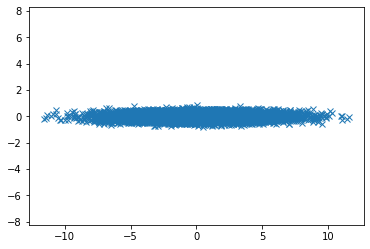

In [5]:
# extract the relevant columns from the centered design matrix of dim n x 2
x = X_centered[:,0]
y = X_centered[:,1]
Cov = np.zeros((2,2))
Cov[0,1] = np.sum(x.T@y)/(n-1.0)
Cov[0,0] = np.sum(x.T@x)/(n-1.0)
Cov[1,1] = np.sum(y.T@y)/(n-1.0)
Cov[1,0]= Cov[0,1]
print("Centered covariance using own code")
print(Cov)
plt.plot(x, y, 'x')
plt.axis('equal')
plt.show()

## Exploring

Depending on the number of points $n$, we will get results that are close to the covariance values defined above.
The plot shows how the data are clustered around a line with slope close to one. Is this expected?  Try to change the covariance and the mean values. For example, try to make the variance of the first element much larger than that of the second diagonal element. Try also to shrink the covariance  (the non-diagonal elements) and see how the data points are distributed.

## Diagonalize the sample covariance matrix to obtain the principal components

Now we are ready to solve for the principal components! To do so we
diagonalize the sample covariance matrix $\Sigma$. We can use the
function **np.linalg.eig** to do so. It will return the eigenvalues and
eigenvectors of $\Sigma$. Once we have these we can perform the 
following tasks:

* We compute the percentage of the total variance captured by the first principal component

* We plot the mean centered data and lines along the first and second principal components

* Then we project the mean centered data onto the first and second principal components, and plot the projected data. 

* Finally, we approximate the data as

$$
x_i \approx \tilde{x}_i = \mu_n + \langle x_i, v_0 \rangle v_0
$$

where $v_0$ is the first principal component.

## Collecting all Steps

Collecting all these steps we can write our own PCA function and
compare this with the functionality included in **Scikit-Learn**.  

The code here outlines some of the elements we could include in the
analysis. Feel free to extend upon this in order to address the above
questions.

In [6]:
# diagonalize and obtain eigenvalues, not necessarily sorted
EigValues, EigVectors = np.linalg.eig(Cov)
# sort eigenvectors and eigenvalues
#permute = EigValues.argsort()
#EigValues = EigValues[permute]
#EigVectors = EigVectors[:,permute]
print("Eigenvalues of Covariance matrix")
for i in range(2):
    print(EigValues[i])
FirstEigvector = EigVectors[:,0]
SecondEigvector = EigVectors[:,1]
print("First eigenvector")
print(FirstEigvector)
print("Second eigenvector")
print(SecondEigvector)
#thereafter we do a PCA with Scikit-learn
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X2Dsl = pca.fit_transform(X)
print("Eigenvector of largest eigenvalue")
print(pca.components_.T[:, 0])

Eigenvalues of Covariance matrix
9.876618994986675
0.0489340085461999
First eigenvector
[0.99999746 0.00225436]
Second eigenvector
[-0.00225436  0.99999746]
Eigenvector of largest eigenvalue
[-0.99999746 -0.00225436]


This code does not contain all the above elements, but it shows how we can use **Scikit-Learn** to extract the eigenvector which corresponds to the largest eigenvalue. Try to address the questions we pose before the above code.  Try also to change the values of the covariance matrix by making one of the diagonal elements much larger than the other. What do you observe then?

## Classical PCA Theorem

We assume now that we have a design matrix $\boldsymbol{X}$ which has been
centered as discussed above. For the sake of simplicity we skip the
overline symbol. The matrix is defined in terms of the various column
vectors $[\boldsymbol{x}_0,\boldsymbol{x}_1,\dots, \boldsymbol{x}_{p-1}]$ each with dimension
$\boldsymbol{x}\in {\mathbb{R}}^{n}$.

The PCA theorem states that minimizing the above reconstruction error
corresponds to setting $\boldsymbol{W}=\boldsymbol{S}$, the orthogonal matrix which
diagonalizes the empirical covariance(correlation) matrix. The optimal
low-dimensional encoding of the data is then given by a set of vectors
$\boldsymbol{z}_i$ with at most $l$ vectors, with $l << p$, defined by the
orthogonal projection of the data onto the columns spanned by the
eigenvectors of the covariance(correlations matrix).

## The PCA Theorem

To show the PCA theorem let us start with the assumption that there is one vector $\boldsymbol{s}_0$ which corresponds to a solution which minimized the reconstruction error $J$. This is an orthogonal vector. It means that we now approximate the reconstruction error in terms of $\boldsymbol{w}_0$ and $\boldsymbol{z}_0$ as

We are almost there, we have obtained a relation between minimizing
the reconstruction error and the variance and the covariance
matrix. Minimizing the error is equivalent to maximizing the variance
of the projected data.

We could trivially maximize the variance of the projection (and
thereby minimize the error in the reconstruction function) by letting
the norm-2 of $\boldsymbol{w}_0$ go to infinity. However, this norm since we
want the matrix $\boldsymbol{W}$ to be an orthogonal matrix, is constrained by
$\vert\vert \boldsymbol{w}_0 \vert\vert_2^2=1$. Imposing this condition via a
Lagrange multiplier we can then in turn maximize

$$
J(\boldsymbol{w}_0)= \boldsymbol{w}_0^T\boldsymbol{C}[\boldsymbol{x}]\boldsymbol{w}_0+\lambda_0(1-\boldsymbol{w}_0^T\boldsymbol{w}_0).
$$

Taking the derivative with respect to $\boldsymbol{w}_0$ we obtain

$$
\frac{\partial J(\boldsymbol{w}_0)}{\partial \boldsymbol{w}_0}= 2\boldsymbol{C}[\boldsymbol{x}]\boldsymbol{w}_0-2\lambda_0\boldsymbol{w}_0=0,
$$

meaning that

$$
\boldsymbol{C}[\boldsymbol{x}]\boldsymbol{w}_0=\lambda_0\boldsymbol{w}_0.
$$

**The direction that maximizes the variance (or minimizes the construction error) is an eigenvector of the covariance matrix**! If we left multiply with $\boldsymbol{w}_0^T$ we have the variance of the projected data is

$$
\boldsymbol{w}_0^T\boldsymbol{C}[\boldsymbol{x}]\boldsymbol{w}_0=\lambda_0.
$$

If we want to maximize the variance (minimize the construction error)
we simply pick the eigenvector of the covariance matrix with the
largest eigenvalue. This establishes the link between the minimization
of the reconstruction function $J$ in terms of an orthogonal matrix
and the maximization of the variance and thereby the covariance of our
observations encoded in the design/feature matrix $\boldsymbol{X}$.

The proof
for the other eigenvectors $\boldsymbol{w}_1,\boldsymbol{w}_2,\dots$ can be
established by applying the above arguments and using the fact that
our basis of eigenvectors is orthogonal, see [Murphy chapter
12.2](https://mitpress.mit.edu/books/machine-learning-1).  The
discussion in chapter 12.2 of Murphy's text has also a nice link with
the Singular Value Decomposition theorem. For categorical data, see
chapter 12.4 and discussion therein.

For more details, see for example [Vidal, Ma and Sastry, chapter 2](https://www.springer.com/gp/book/9780387878102).

## Geometric Interpretation and link with Singular Value Decomposition

For a detailed demonstration of the geometric interpretation, see [Vidal, Ma and Sastry, section 2.1.2](https://www.springer.com/gp/book/9780387878102).

Principal Component Analysis (PCA) is by far the most popular dimensionality reduction algorithm.
First it identifies the hyperplane that lies closest to the data, and then it projects the data onto it.

The following Python code uses NumPy’s **svd()** function to obtain all the principal components of the
training set, then extracts the first two principal components. First we center the data using either **pandas** or our own code

In [7]:
import numpy as np
import pandas as pd
from IPython.display import display
np.random.seed(100)
# setting up a 10 x 5 vanilla matrix 
rows = 10
cols = 5
X = np.random.randn(rows,cols)
df = pd.DataFrame(X)
# Pandas does the centering for us
df = df -df.mean()
display(df)

# we center it ourselves
X_centered = X - X.mean(axis=0)
# Then check the difference between pandas and our own set up
print(X_centered-df)
#Now we do an SVD
U, s, V = np.linalg.svd(X_centered)
c1 = V.T[:, 0]
c2 = V.T[:, 1]
W2 = V.T[:, :2]
X2D = X_centered.dot(W2)
print(X2D)

,0,1,2,3,4
0,-1.574465,0.259153,1.197370,0.147400,0.649382
1,0.689519,0.137652,-1.025709,0.210340,-0.076938
2,-0.282727,0.351636,-0.539261,1.216683,0.340782
3,0.070889,-0.614808,1.074067,-0.038300,-1.450257
4,1.794282,1.458078,-0.207545,-0.442600,-0.147420
5,1.112383,0.647473,1.405890,0.073598,-0.276263
6,0.397700,-1.526744,-0.712018,1.216290,0.418506
7,-0.280647,1.106095,-1.646283,-0.956563,-1.564374
8,-0.369139,-0.751699,0.051649,-0.213103,0.967809
9,-1.557795,-1.066837,0.401842,-1.213743,1.138775


     0    1    2    3    4
0  0.0  0.0  0.0  0.0  0.0
1  0.0  0.0  0.0  0.0  0.0
2  0.0  0.0  0.0  0.0  0.0
3  0.0  0.0  0.0  0.0  0.0
4  0.0  0.0  0.0  0.0  0.0
5  0.0  0.0  0.0  0.0  0.0
6  0.0  0.0  0.0  0.0  0.0
7  0.0  0.0  0.0  0.0  0.0
8  0.0  0.0  0.0  0.0  0.0
9  0.0  0.0  0.0  0.0  0.0
[[-1.5378811  -0.94639099]
 [ 0.86145244  0.89288636]
 [-0.00445655  0.81633628]
 [ 0.07145103 -1.00433417]
 [ 2.03707133 -0.48476997]
 [ 0.72174172 -1.4557763 ]
 [-0.55854694  1.60673226]
 [ 1.6999536   0.43766686]
 [-1.10405456  0.31718909]
 [-2.18673098 -0.17953942]]


PCA assumes that the dataset is centered around the origin. Scikit-Learn’s PCA classes take care of centering
the data for you. However, if you implement PCA yourself (as in the preceding example), or if you use other libraries, don’t
forget to center the data first.

Once you have identified all the principal components, you can reduce the dimensionality of the dataset
down to $d$ dimensions by projecting it onto the hyperplane defined by the first $d$ principal components.
Selecting this hyperplane ensures that the projection will preserve as much variance as possible.

In [8]:
W2 = V.T[:, :2]
X2D = X_centered.dot(W2)

## PCA and scikit-learn

Scikit-Learn’s PCA class implements PCA using SVD decomposition just like we did before. The
following code applies PCA to reduce the dimensionality of the dataset down to two dimensions (note
that it automatically takes care of centering the data):

In [9]:
#thereafter we do a PCA with Scikit-learn
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)
print(X2D)

[[ 1.5378811  -0.94639099]
 [-0.86145244  0.89288636]
 [ 0.00445655  0.81633628]
 [-0.07145103 -1.00433417]
 [-2.03707133 -0.48476997]
 [-0.72174172 -1.4557763 ]
 [ 0.55854694  1.60673226]
 [-1.6999536   0.43766686]
 [ 1.10405456  0.31718909]
 [ 2.18673098 -0.17953942]]


After fitting the PCA transformer to the dataset, you can access the principal components using the
components variable (note that it contains the PCs as horizontal vectors, so, for example, the first
principal component is equal to

In [10]:
pca.components_.T[:, 0]

array([-0.62373464, -0.5303329 ,  0.317367  ,  0.01873344,  0.47815203])

Another very useful piece of information is the explained variance ratio of each principal component,
available via the $explained\_variance\_ratio$ variable. It indicates the proportion of the dataset’s
variance that lies along the axis of each principal component.

## Back to the Cancer Data
We can now repeat the above but applied to real data, in this case our breast cancer data.
Here we compute performance scores on the training data using logistic regression.

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import  train_test_split 
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data,cancer.target,random_state=0)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print("Train set accuracy from Logistic Regression: {:.2f}".format(logreg.score(X_train,y_train)))
# We scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Then perform again a log reg fit
logreg.fit(X_train_scaled, y_train)
print("Train set accuracy scaled data: {:.2f}".format(logreg.score(X_train_scaled,y_train)))
#thereafter we do a PCA with Scikit-learn
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X2D_train = pca.fit_transform(X_train_scaled)
# and finally compute the log reg fit and the score on the training data	
logreg.fit(X2D_train,y_train)
print("Train set accuracy scaled and PCA data: {:.2f}".format(logreg.score(X2D_train,y_train)))

Train set accuracy from Logistic Regression: 0.95
Train set accuracy scaled data: 0.99
Train set accuracy scaled and PCA data: 0.96


/Users/mhjensen/Software/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


We see that our training data after the PCA decomposition has a performance similar to the non-scaled data. 

Instead of arbitrarily choosing the number of dimensions to reduce down to, it is generally preferable to
choose the number of dimensions that add up to a sufficiently large portion of the variance (e.g., 95%).
Unless, of course, you are reducing dimensionality for data visualization — in that case you will
generally want to reduce the dimensionality down to 2 or 3.
The following code computes PCA without reducing dimensionality, then computes the minimum number
of dimensions required to preserve 95% of the training set’s variance:

In [12]:
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

You could then set $n\_components=d$ and run PCA again. However, there is a much better option: instead
of specifying the number of principal components you want to preserve, you can set $n\_components$ to be
a float between 0.0 and 1.0, indicating the ratio of variance you wish to preserve:

In [13]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X)

## Incremental PCA

One problem with the preceding implementation of PCA is that it requires the whole training set to fit in
memory in order for the SVD algorithm to run. Fortunately, Incremental PCA (IPCA) algorithms have
been developed: you can split the training set into mini-batches and feed an IPCA algorithm one minibatch
at a time. This is useful for large training sets, and also to apply PCA online (i.e., on the fly, as new
instances arrive).

### Randomized PCA

Scikit-Learn offers yet another option to perform PCA, called Randomized PCA. This is a stochastic
algorithm that quickly finds an approximation of the first d principal components. Its computational
complexity is $O(m \times d^2)+O(d^3)$, instead of $O(m \times n^2) + O(n^3)$, so it is dramatically faster than the
previous algorithms when $d$ is much smaller than $n$.

### Kernel PCA

The kernel trick is a mathematical technique that implicitly maps instances into a
very high-dimensional space (called the feature space), enabling nonlinear classification and regression
with Support Vector Machines. Recall that a linear decision boundary in the high-dimensional feature
space corresponds to a complex nonlinear decision boundary in the original space.
It turns out that the same trick can be applied to PCA, making it possible to perform complex nonlinear
projections for dimensionality reduction. This is called Kernel PCA (kPCA). It is often good at
preserving clusters of instances after projection, or sometimes even unrolling datasets that lie close to a
twisted manifold.
For example, the following code uses Scikit-Learn’s KernelPCA class to perform kPCA with an

In [14]:
from sklearn.decomposition import KernelPCA
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

## Other techniques

There are many other dimensionality reduction techniques, several of which are available in Scikit-Learn.

Here are some of the most popular:
* **Multidimensional Scaling (MDS)** reduces dimensionality while trying to preserve the distances between the instances.

* **Isomap** creates a graph by connecting each instance to its nearest neighbors, then reduces dimensionality while trying to preserve the geodesic distances between the instances.

* **t-Distributed Stochastic Neighbor Embedding** (t-SNE) reduces dimensionality while trying to keep similar instances close and dissimilar instances apart. It is mostly used for visualization, in particular to visualize clusters of instances in high-dimensional space (e.g., to visualize the MNIST images in 2D).

* Linear Discriminant Analysis (LDA) is actually a classification algorithm, but during training it learns the most discriminative axes between the classes, and these axes can then be used to define a hyperplane onto which to project the data. The benefit is that the projection will keep classes as far apart as possible, so LDA is a good technique to reduce dimensionality before running another classification algorithm such as a Support Vector Machine (SVM) classifier discussed in the SVM lectures.